Sentiment Analysis


1. Average sentiment of each video


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "meta-llama/Meta-Llama-3-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")

topic = "israel vs hamas"
sentence = "Name me 1 thing Islam has brought to the world since 64 ad....1."

prompt = f"""You are a stance detection assistant.
Given a topic and a sentence, classify the sentence as one of: supporting, against, or neutral.

Topic: {topic}
Sentence: "{sentence}"
Answer with one word only:"""

inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
outputs = model.generate(
    **inputs, max_new_tokens=10, temperature=0.0
)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))


OSError: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/google/gemma-7b-it.
401 Client Error. (Request ID: Root=1-685b1577-089220334fa4f6ae1aa8d008;e7060868-b908-4f48-aa41-7e847e73b538)

Cannot access gated repo for url https://huggingface.co/google/gemma-7b-it/resolve/main/config.json.
Access to model google/gemma-7b-it is restricted. You must have access to it and be authenticated to access it. Please log in.

     Sentiment Analysis (VADER)


In [70]:
import pandas as pd 

# load the csv file
df = pd.read_csv("comments_processing2.csv")

# make sure that the title is a string
df['title'] = df['title'].astype(str)

# Count comments per video
comment_counts = df['video_id'].value_counts()

# Get top 10 most commented videos
top10_ids = comment_counts.head(20).index

#filter data to top 10 videos
top10_df = df[df['video_id'].isin(top10_ids)]

#group by sentiment 
sentiment_counts = top10_df.groupby(['video_id', 'sentiment_class']).size().unstack(fill_value=0)

#get each percentage
sentiment_percentages = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0)

# Get average percentage across the 10 videos
avg_sentiment = sentiment_percentages.mean().sort_values(ascending=False)


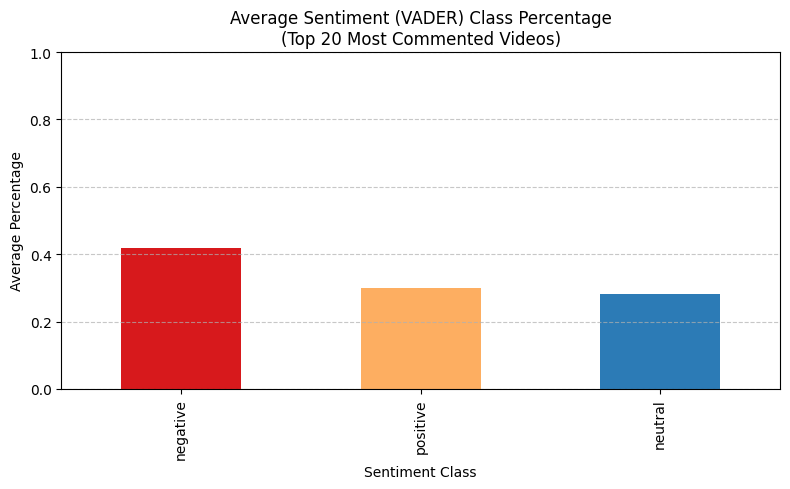

In [72]:
# visualization
import matplotlib.pyplot as plt 

avg_sentiment.plot(
    kind='bar',
    color=['#d7191c', '#fdae61', '#2c7bb6'],  # negative, neutral, positive
    figsize=(8, 5)
)
plt.title('Average Sentiment (VADER) Class Percentage\n(Top 20 Most Commented Videos)')
plt.ylabel('Average Percentage')
plt.xlabel('Sentiment Class')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

    DistilRoBERTa - Emotion analysis


In [73]:
import pandas as pd
import matplotlib.pyplot as plt 

#load csv
df  = pd.read_csv("comments_processing2.csv")

df['title'] = df['title'].astype(str)

top10_ids = df['video_id'].value_counts().head(20).index

top10_df = df[df['video_id'].isin(top10_ids)]



emotion_labels = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']


emotion_counts = df.groupby(['video_id', 'emotion']).size().unstack(fill_value=0)


emotion_percentages = emotion_counts.div(emotion_counts.sum(axis=1), axis=0)

video_titles = df[['video_id','title']].drop_duplicates(subset='video_id')
emotion_counts = emotion_counts.merge(video_titles, on='video_id', how='left')

avg_emotion = emotion_percentages.mean().sort_values(ascending=False)


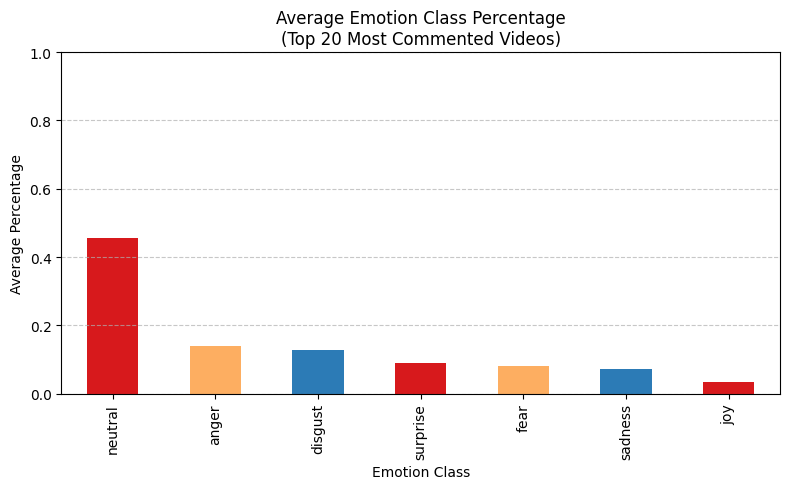

In [74]:
avg_emotion.plot(
    kind='bar',
    color=['#d7191c', '#fdae61', '#2c7bb6'],  # negative, neutral, positive
    figsize=(8, 5)
)
plt.title('Average Emotion Class Percentage\n(Top 20 Most Commented Videos)')
plt.ylabel('Average Percentage')
plt.xlabel('Emotion Class')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

    Emotion polarity


In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 

# load my csv file 
df = pd.read_csv("comments_processing2.csv")

# Make sure that the title is a string
df['title'] = df['title'].astype(str)

# count the comments per video (to find the top 10 commented videos)
comment_count = df['video_id'].value_counts()

# get the top 10 commented videos 
top10_commented = comment_count.head(20).index

# filter data to top 10 videos 
top10_df = df[df['video_id'].isin(top10_commented)]

# group by video and emotion polarity 
polarity_counts = top10_df.groupby(['video_id','emotion_polarity']).size().unstack(fill_value=0)

# convert counts to percentages 
polarity_percentages = polarity_counts.div(polarity_counts.sum(axis=1), axis=0)

# For all 10 videos, get the average polarity percentages 
average_polarity = polarity_percentages.mean().sort_values(ascending=False)


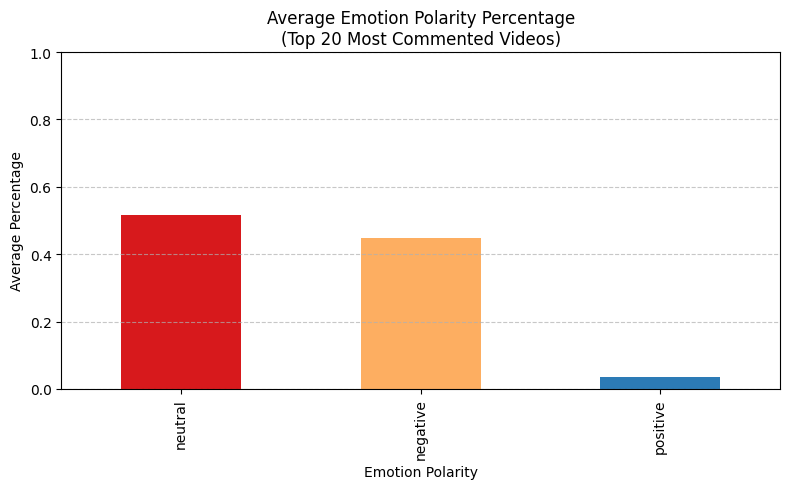

In [91]:
#plot the chart 
average_polarity.plot(
    kind='bar',
    color=['#d7191c', '#fdae61', '#2c7bb6'],  # red, orange, blue for negative, neutral, positive
    figsize=(8, 5)
)

plt.title('Average Emotion Polarity Percentage\n(Top 20 Most Commented Videos)')
plt.ylabel('Average Percentage')
plt.xlabel('Emotion Polarity')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


2. Percentage of Reply comments that have the same sentiment as the root


    Vader (sentiment)


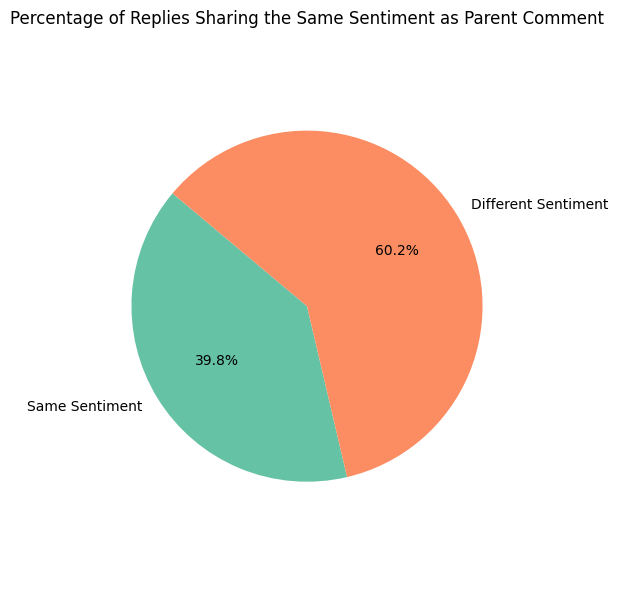

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

#load data
df = pd.read_csv("comments_processing2.csv")

#lookup from commment id to sentiment class
sentiment_lookup = df.set_index('comment_id')['sentiment_class']

#get the comments that have a parent
replies_df = df[df['parent_id'].notnull() & df['parent_id'].isin(sentiment_lookup.index)]

#compare sentiment of the reply with it's parent 
replies_df = replies_df.copy()
replies_df['parent_sentiment'] = replies_df['parent_id'].map(sentiment_lookup)

#check if the sentiment matches 
replies_df['sentiment_match'] = replies_df['sentiment_class'] == replies_df['parent_sentiment']

#count number of matches vs. mismatches
match_counts = replies_df['sentiment_match'].value_counts()

#-------------------------------- Labels and plotting ---------------------------------------------------------
labels = ['Same Sentiment', 'Different Sentiment']
sizes = [
    match_counts.get(True, 0),
    match_counts.get(False, 0)
]

colors = ['#66c2a5', '#fc8d62']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Replies Sharing the Same Sentiment as Parent Comment')
plt.axis('equal')  # Equal aspect ratio ensures pie is a circle
plt.tight_layout()
plt.show()






    DistilRoBERTa (Emotion)


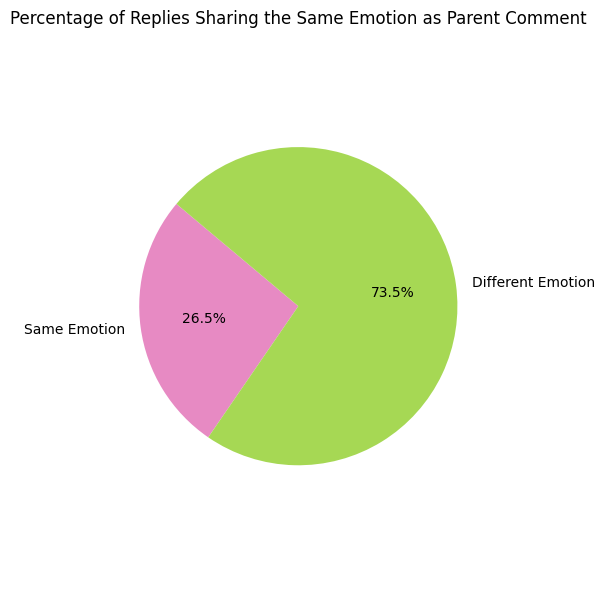

In [50]:
import pandas as pd 
import matplotlib.pyplot as plt 

#import data
df = pd.read_csv("comments_processing2.csv")

#lookup from commment id to emotion class
emotion_lookup = df.set_index('comment_id')['emotion']

#get the comments that have a parent
replies_df = df[df['parent_id'].notnull() & df['parent_id'].isin(emotion_lookup.index)]

#compare emotion of the reply with it's parent 
replies_df = replies_df.copy()
replies_df['parent_emotion'] = replies_df['parent_id'].map(emotion_lookup)

#check if the sentiment matches 
replies_df['emotion_match'] = replies_df['emotion'] == replies_df['parent_emotion']

#count number of matches vs. mismatches
match_counts = replies_df['emotion_match'].value_counts()

#-------------------------------- Labels and plotting ---------------------------------------------------------
labels = ['Same Emotion', 'Different Emotion']
sizes = [
    match_counts.get(True, 0),
    match_counts.get(False, 0)
]

colors = ['#e78ac3', '#a6d854'] 

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Replies Sharing the Same Emotion as Parent Comment')
plt.axis('equal')  # Equal aspect ratio ensures pie is a circle
plt.tight_layout()
plt.show()






    Emotion Polarity


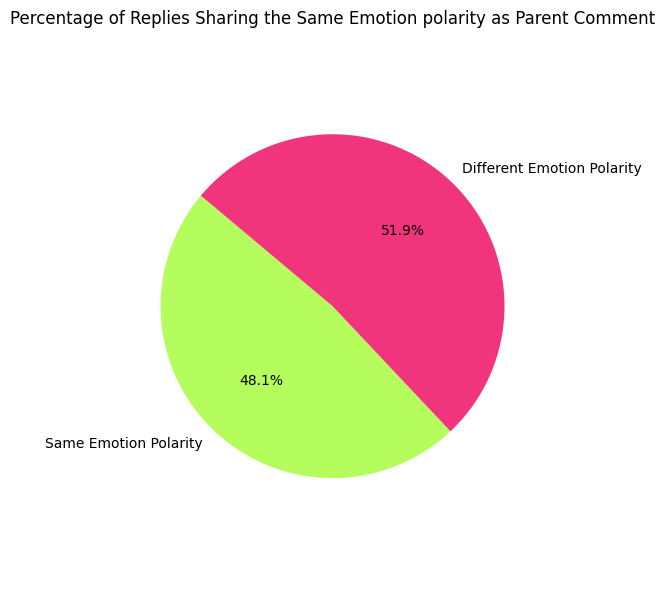

In [53]:
import pandas as pd 
import matplotlib.pyplot as plt 

#import data
df = pd.read_csv("comments_processing2.csv")

#lookup from commment id to emotion class
polarity_lookup = df.set_index('comment_id')['emotion_polarity']

#get the comments that have a parent
replies_df = df[df['parent_id'].notnull() & df['parent_id'].isin(polarity_lookup.index)]

#compare emotion polarity of the reply with it's parent 
replies_df = replies_df.copy()
replies_df['parent_emotion_polarity'] = replies_df['parent_id'].map(polarity_lookup)

#check if the sentiment matches 
replies_df['polarity_match'] = replies_df['emotion_polarity'] == replies_df['parent_emotion_polarity']

#count number of matches vs. mismatches
match_counts = replies_df['polarity_match'].value_counts()

#-------------------------------- Labels and plotting ---------------------------------------------------------
labels = ['Same Emotion Polarity', 'Different Emotion Polarity']
sizes = [
    match_counts.get(True, 0),
    match_counts.get(False, 0)
]

colors = ['#b5fc5d', '#f0357c'] 

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Replies Sharing the Same Emotion polarity as Parent Comment')
plt.axis('equal')  # Equal aspect ratio ensures pie is a circle
plt.tight_layout()
plt.show()






3. Relationship between Sentiment and the number of replies


    Sentiment (VADER)


Data to plot:
 sentiment_class
negative    6.148421
positive    4.937340
neutral     4.676768
Name: num_replies, dtype: float64
Empty? False


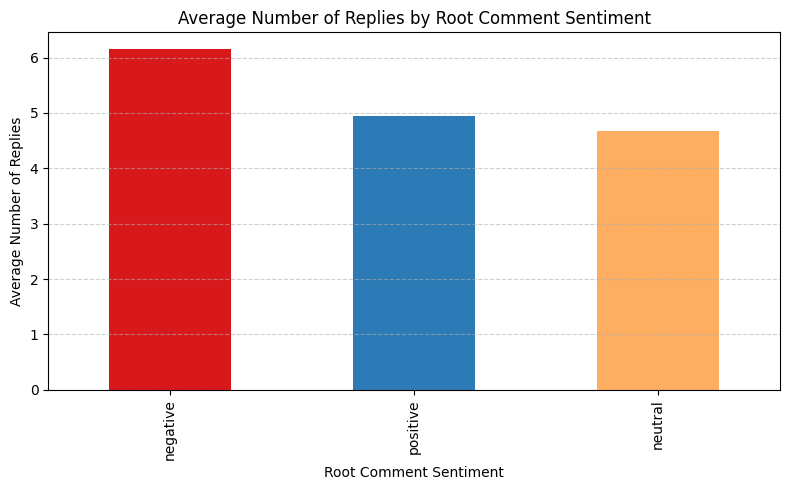

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv("comments_processing2.csv")

# Filter root comments (dont have a parent)
root_comments = df[df['parent_id']=='root']

# Count replies per root comment_id
reply_counts = df['parent_id'].value_counts()

# Add reply count to each root comment
root_comments = root_comments.copy()
root_comments['num_replies'] = root_comments['comment_id'].map(reply_counts).fillna(0).astype(int)

# Group by sentiment_class and calculate average number of replies
avg_replies_by_sentiment = root_comments.groupby('sentiment_class')['num_replies'].mean().sort_values(ascending=False)

print("Data to plot:\n", avg_replies_by_sentiment)
print("Empty?", avg_replies_by_sentiment.empty)
# Plot
colors = {
    'negative': '#d7191c',
    'neutral': '#fdae61',
    'positive': '#2c7bb6'
}  
bar_colors = [colors.get(sent, '#cccccc') for sent in avg_replies_by_sentiment.index]

avg_replies_by_sentiment.plot(
    kind='bar',
    color=bar_colors,
    figsize=(8, 5)
)
plt.title('Average Number of Replies by Root Comment Sentiment')
plt.ylabel('Average Number of Replies')
plt.xlabel('Root Comment Sentiment')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


    Emotion (DistilRoBERTa)


Data to plot:
 emotion
disgust     7.522936
joy         7.193370
sadness     5.697521
anger       5.161031
fear        5.159420
surprise    4.955000
neutral     4.563562
Name: num_replies, dtype: float64
Empty? False


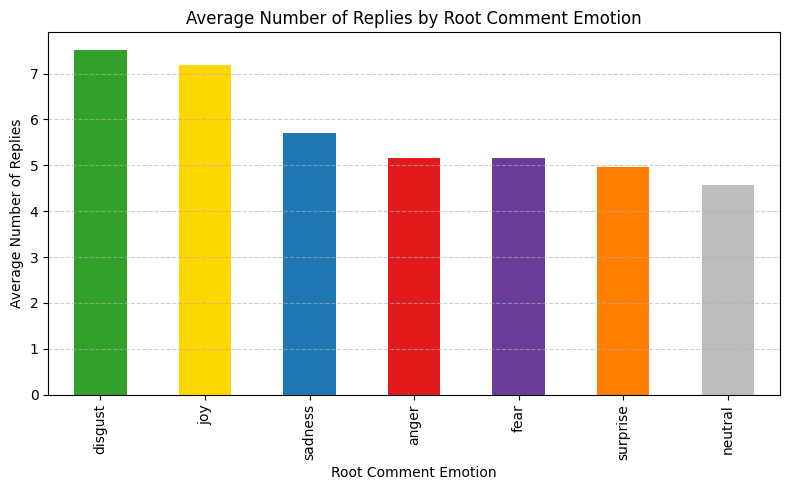

In [92]:
import pandas as pd 
import matplotlib.pyplot as plt

# import data 
df = pd.read_csv("comments_processing2.csv")

# Filter root comments (dont have a parent)
root_comments = df[df['parent_id']=='root']

# Count replies per root comment_id
reply_counts = df['parent_id'].value_counts()

# Add reply count to each root comment
root_comments = root_comments.copy()
root_comments['num_replies'] = root_comments['comment_id'].map(reply_counts).fillna(0).astype(int)

# Group by emotion and calculate average number of replies
avg_replies_by_emotion = root_comments.groupby('emotion')['num_replies'].mean().sort_values(ascending=False)

print("Data to plot:\n", avg_replies_by_emotion)
print("Empty?", avg_replies_by_emotion.empty)
# Plot
colors = {
    'joy': '#ffd700',         # gold
    'sadness': '#1f78b4',     # blue
    'anger': '#e31a1c',       # red
    'fear': '#6a3d9a',        # purple
    'disgust': '#33a02c',     # green
    'surprise': '#ff7f00',    # orange
    'neutral': '#bdbdbd'      # gray
}

bar_colors = [colors.get(sent, '#cccccc') for sent in avg_replies_by_emotion.index]

avg_replies_by_emotion.plot(
    kind='bar',
    color=bar_colors,
    figsize=(8, 5)
)
plt.title('Average Number of Replies by Root Comment Emotion')
plt.ylabel('Average Number of Replies')
plt.xlabel('Root Comment Emotion')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()





    Emotion Polarity


Data to plot:
 emotion_polarity
positive    7.193370
negative    5.860076
neutral     4.634604
Name: num_replies, dtype: float64
Empty? False


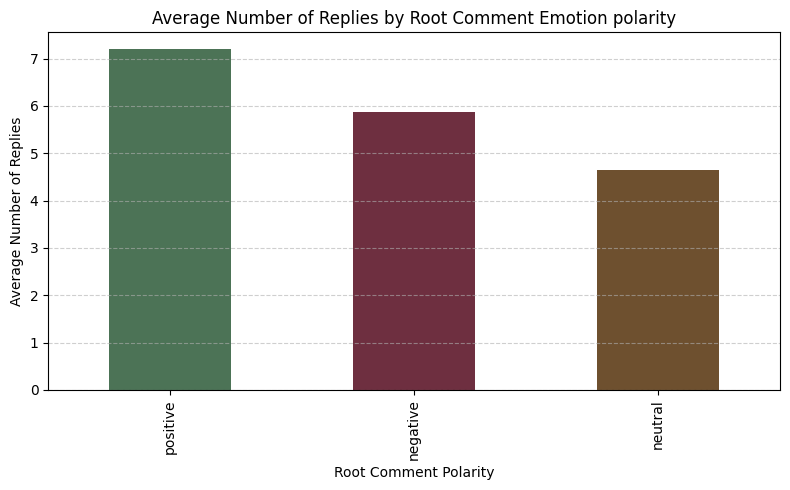

In [94]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv("comments_processing2.csv")

# Filter root comments (dont have a parent)
root_comments = df[df['parent_id']=='root']

# Count replies per root comment_id
reply_counts = df['parent_id'].value_counts()

# Add reply count to each root comment
root_comments = root_comments.copy()
root_comments['num_replies'] = root_comments['comment_id'].map(reply_counts).fillna(0).astype(int)

# Group by sentiment_class and calculate average number of replies
avg_replies_by_polarity = root_comments.groupby('emotion_polarity')['num_replies'].mean().sort_values(ascending=False)

print("Data to plot:\n", avg_replies_by_polarity)
print("Empty?", avg_replies_by_polarity.empty)
# Plot
colors = {
    'negative': '#6e2f40',
    'neutral': '#6e502f',
    'positive': '#4c7356'
}  
bar_colors = [colors.get(sent, '#cccccc') for sent in avg_replies_by_polarity.index]

avg_replies_by_polarity.plot(
    kind='bar',
    color=bar_colors,
    figsize=(8, 5)
)
plt.title('Average Number of Replies by Root Comment Emotion polarity')
plt.ylabel('Average Number of Replies')
plt.xlabel('Root Comment Polarity')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


4. Correlation beteween the number of likes and sentiment of the comment


    Sentiment (VADER)


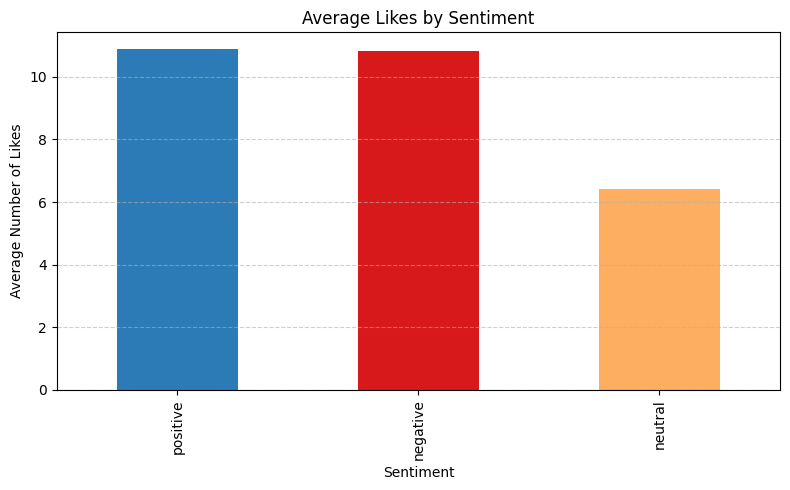

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv("comments_processing2.csv")

# Clean sentiment values
df['sentiment_class'] = df['sentiment_class'].str.lower().fillna('unknown')

# Convert likes to numeric (in case there are any weird entries)
df['likes'] = pd.to_numeric(df['likes'], errors='coerce')

# Group by sentiment and compute average likes
avg_likes_by_sentiment = df.groupby('sentiment_class')['likes'].mean().sort_values(ascending=False)

# Define colors for each sentiment
colors = {
    'positive': '#2c7bb6',
    'neutral': '#fdae61',
    'negative': '#d7191c',
    'unknown': '#cccccc'
}
bar_colors = [colors.get(sent, '#cccccc') for sent in avg_likes_by_sentiment.index]

# Plot
avg_likes_by_sentiment.plot(
    kind='bar',
    color=bar_colors,
    figsize=(8, 5)
)
plt.title('Average Likes by Sentiment')
plt.ylabel('Average Number of Likes')
plt.xlabel('Sentiment')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


    Emotion (DistilRoBERTa)


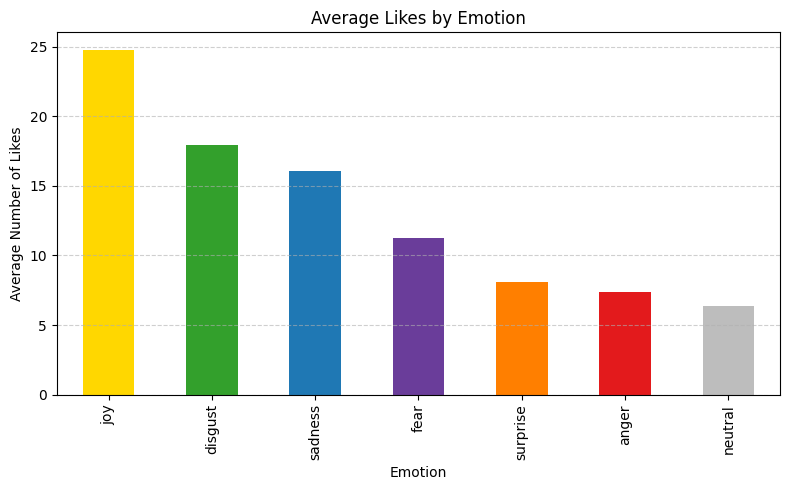

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv("comments_processing2.csv")

# Clean emotion values
df['emotion'] = df['emotion'].str.lower().fillna('unknown')

# Convert likes to numeric (in case there are any weird entries)
df['likes'] = pd.to_numeric(df['likes'], errors='coerce')

# Group by sentiment and compute average likes
avg_likes_by_sentiment = df.groupby('emotion')['likes'].mean().sort_values(ascending=False)

# Define colors for each sentiment
colors = {
    'joy': '#ffd700',         # gold
    'sadness': '#1f78b4',     # blue
    'anger': '#e31a1c',       # red
    'fear': '#6a3d9a',        # purple
    'disgust': '#33a02c',     # green
    'surprise': '#ff7f00',    # orange
    'neutral': '#bdbdbd'      # gray
}
bar_colors = [colors.get(sent, '#cccccc') for sent in avg_likes_by_sentiment.index]

# Plot
avg_likes_by_sentiment.plot(
    kind='bar',
    color=bar_colors,
    figsize=(8, 5)
)
plt.title('Average Likes by Emotion')
plt.ylabel('Average Number of Likes')
plt.xlabel('Emotion')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


    Emotion Polarity


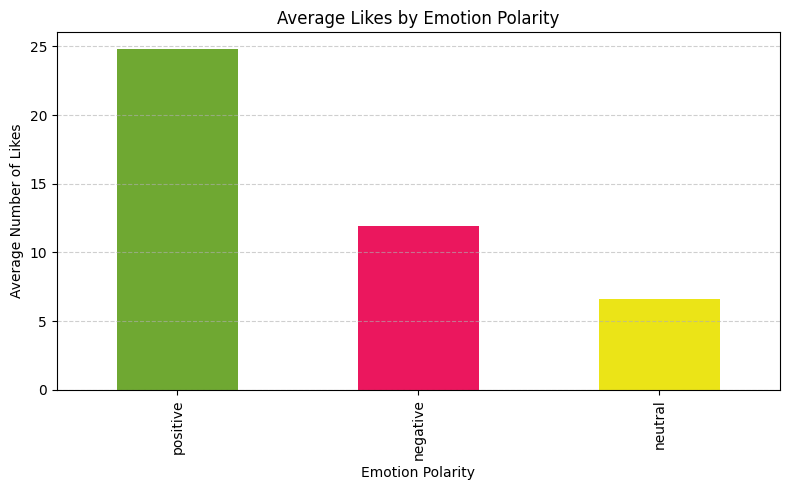

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv("comments_processing2.csv")

# Clean sentiment values
df['emotion_polarity'] = df['emotion_polarity'].str.lower().fillna('unknown')

# Convert likes to numeric (in case there are any weird entries)
df['likes'] = pd.to_numeric(df['likes'], errors='coerce')

# Group by sentiment and compute average likes
avg_likes_by_polarity = df.groupby('emotion_polarity')['likes'].mean().sort_values(ascending=False)

# Define colors for each sentiment
colors = {
    'positive': '#6fa832',
    'neutral': '#ebe417',
    'negative': '#eb175e',
    'unknown': '#cccccc'
}
bar_colors = [colors.get(sent, '#cccccc') for sent in avg_likes_by_polarity.index]

# Plot
avg_likes_by_polarity.plot(
    kind='bar',
    color=bar_colors,
    figsize=(8, 5)
)
plt.title('Average Likes by Emotion Polarity')
plt.ylabel('Average Number of Likes')
plt.xlabel('Emotion Polarity')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


5. Sentiment distribution in videos


    Sentiment (VADER)


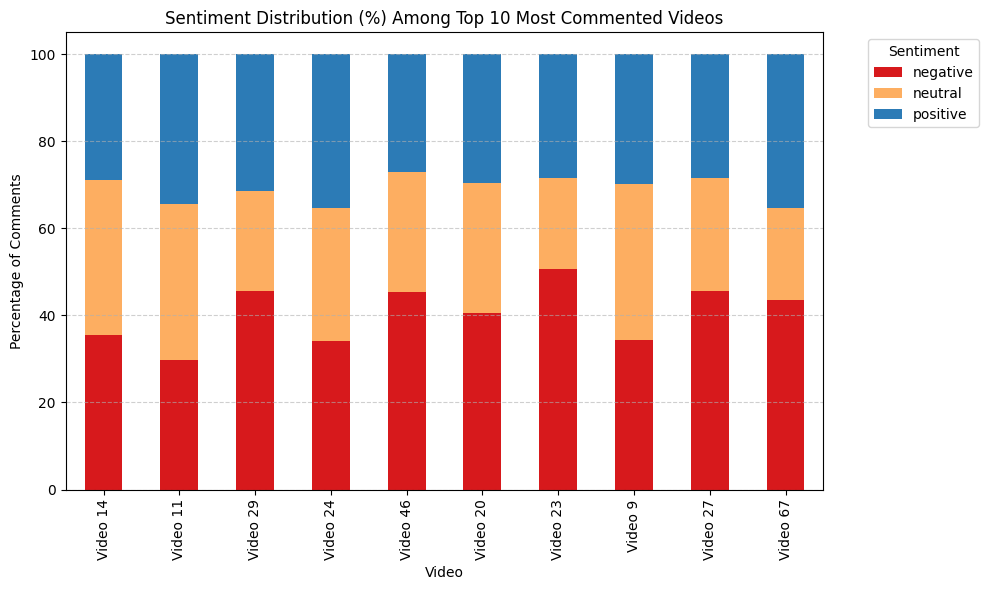

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("comments_processing2.csv")

# Clean up
df['sentiment_class'] = df['sentiment_class'].str.lower().fillna('unknown')

# Count sentiments per video
sentiment_dist = df.groupby(['video_label', 'sentiment_class']).size().unstack(fill_value=0)

# (Optional) Normalize to percentage per video
sentiment_percent = sentiment_dist.div(sentiment_dist.sum(axis=1), axis=0) * 100

# Sort by total comments per video (optional: top 10 only)
top_videos = sentiment_dist.sum(axis=1).sort_values(ascending=False).head(10).index
sentiment_percent = sentiment_percent.loc[top_videos]

# Plot
sentiment_percent.plot(
    kind='bar',
    stacked=True,
    color={
        'positive': '#2c7bb6',
        'neutral': '#fdae61',
        'negative': '#d7191c',
        'unknown': '#cccccc'
    },
    figsize=(10, 6)
)

plt.title('Sentiment Distribution (%) Among Top 10 Most Commented Videos')
plt.ylabel('Percentage of Comments')
plt.xlabel('Video')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


    Emotion (DistilRoBERTa)


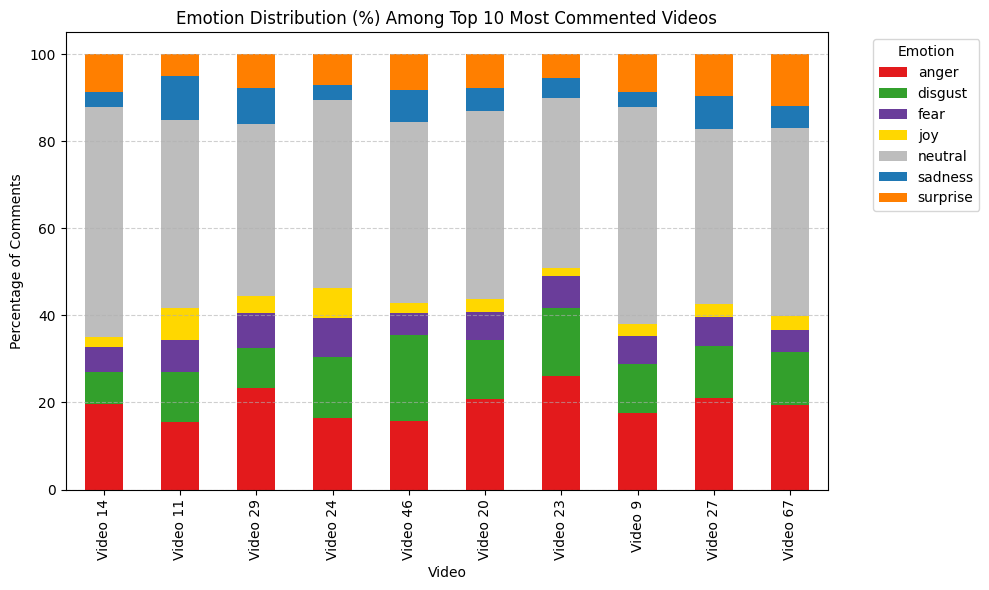

In [95]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("comments_processing2.csv")

# Clean up
df['emotion'] = df['emotion'].str.lower().fillna('unknown')

# Count sentiments per video
emotion_dist = df.groupby(['video_label', 'emotion']).size().unstack(fill_value=0)

# (Optional) Normalize to percentage per video
emotion_percent = emotion_dist.div(emotion_dist.sum(axis=1), axis=0) * 100

# Sort by total comments per video (top 10)
top_videos = emotion_dist.sum(axis=1).sort_values(ascending=False).head(10).index
emotion_percent = emotion_percent.loc[top_videos]

# Plot
emotion_percent.plot(
    kind='bar',
    stacked=True,
    color = {
    'joy': '#ffd700',         # gold
    'sadness': '#1f78b4',     # blue
    'anger': '#e31a1c',       # red
    'fear': '#6a3d9a',        # purple
    'disgust': '#33a02c',     # green
    'surprise': '#ff7f00',    # orange
    'neutral': '#bdbdbd'      # gray
},
    figsize=(10, 6)
)

plt.title('Emotion Distribution (%) Among Top 10 Most Commented Videos')
plt.ylabel('Percentage of Comments')
plt.xlabel('Video')
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

    Emotion Polarity


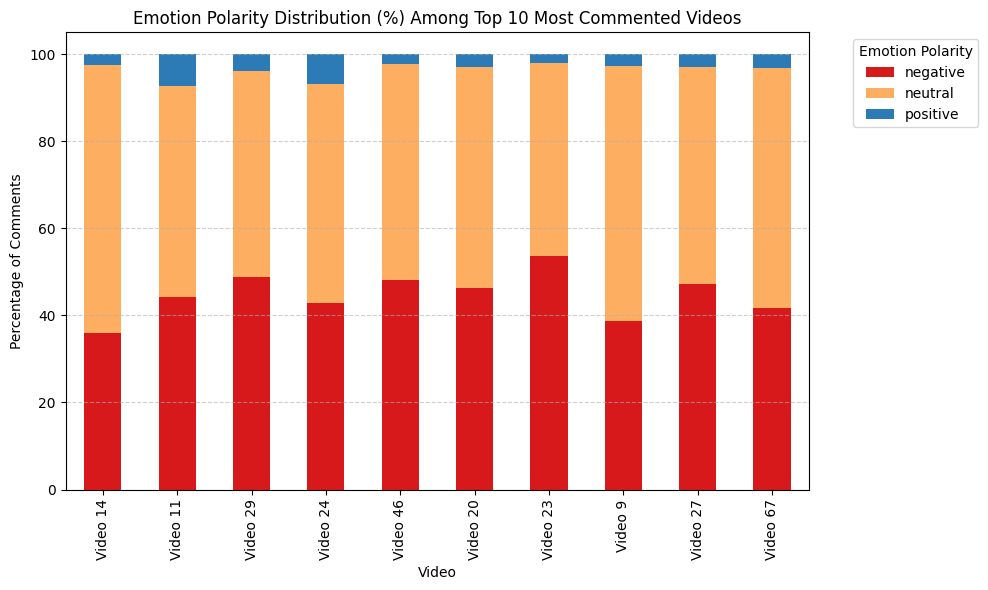

In [82]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("comments_processing2.csv")

# Clean up
df['emotion_polarity'] = df['emotion_polarity'].str.lower().fillna('unknown')

# Count sentiments per video
polarity_dist = df.groupby(['video_label', 'emotion_polarity']).size().unstack(fill_value=0)

# (Optional) Normalize to percentage per video
polarity_percent = polarity_dist.div(polarity_dist.sum(axis=1), axis=0) * 100

# Sort by total comments per video (optional: top 10 only)
top_videos = polarity_dist.sum(axis=1).sort_values(ascending=False).head(10).index
polarity_percent = polarity_percent.loc[top_videos]

# Plot
polarity_percent.plot(
    kind='bar',
    stacked=True,
    color={
        'positive': '#2c7bb6',
        'neutral': '#fdae61',
        'negative': '#d7191c',
        'unknown': '#cccccc'
    },
    figsize=(10, 6)
)

plt.title('Emotion Polarity Distribution (%) Among Top 10 Most Commented Videos')
plt.ylabel('Percentage of Comments')
plt.xlabel('Video')
plt.legend(title='Emotion Polarity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


6. Which emotion (fear, anger, disgust or sadness) are negative comments driven by?


    Sentiment (VADER)


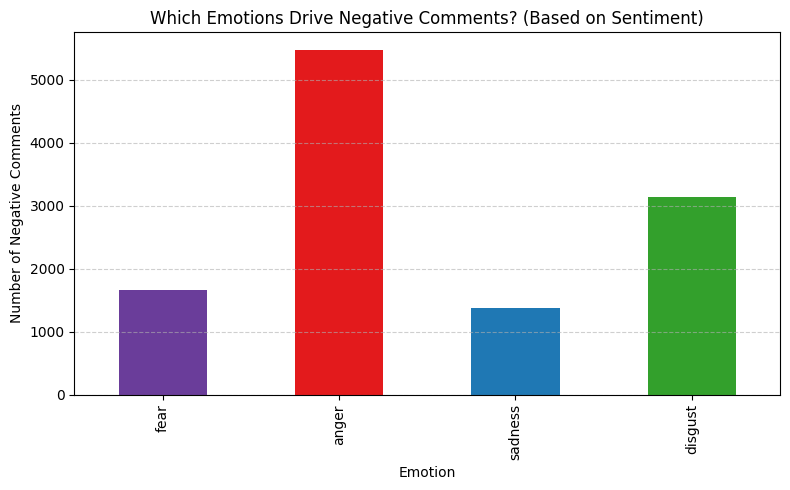

In [96]:
import pandas as pd 
import matplotlib.pyplot as plt 

# import csv data 
df = pd.read_csv("comments_processing2.csv")

# filter for negative sentiment 
negative_comments = df[df['sentiment_class'].str.lower()=='negative']

# count the negative emotions 
negative_emotions = ['fear','anger', 'sadness', 'disgust']
negative_emotion_count = (
    negative_comments['emotion'].value_counts().reindex(negative_emotions, fill_value=0)
)

#colors for the negative emotions 
emotion_colors = {
    'fear': '#6a3d9a',
    'anger': '#e31a1c',
    'sadness': '#1f78b4',
    'disgust': '#33a02c'
}
bar_colors = [emotion_colors.get(e, '#cccccc') for e in negative_emotion_count.index]

#plot the chart 
plt.figure(figsize=(8, 5))
negative_emotion_count.plot(kind='bar', color=bar_colors)

plt.title('Which Emotions Drive Negative Comments? (Based on Sentiment)')
plt.xlabel('Emotion')
plt.ylabel('Number of Negative Comments')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


    Emotion Polarity


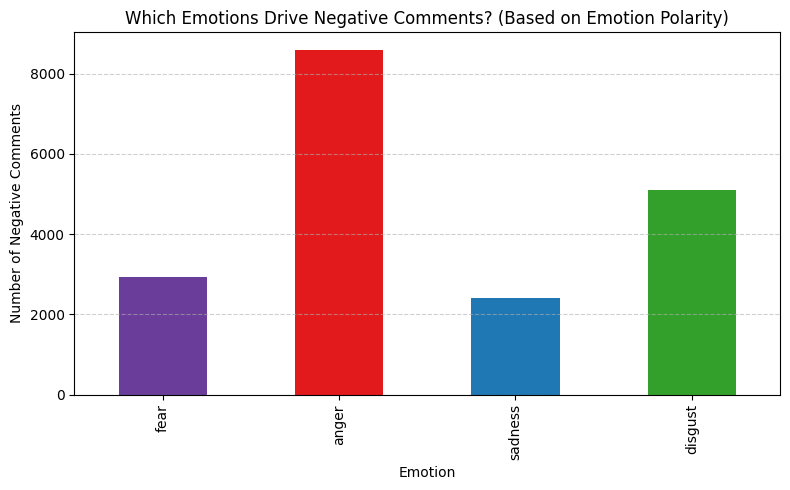

In [97]:
import pandas as pd 
import matplotlib.pyplot as plt 

# import csv data 
df = pd.read_csv("comments_processing2.csv")

# filter for negative sentiment 
negative_comments = df[df['emotion_polarity'].str.lower()=='negative']

# count the negative emotions 
negative_emotions = ['fear','anger', 'sadness', 'disgust']
negative_emotion_count = (
    negative_comments['emotion'].value_counts().reindex(negative_emotions, fill_value=0)
)

#colors for the negative emotions 
emotion_colors = {
    'fear': '#6a3d9a',
    'anger': '#e31a1c',
    'sadness': '#1f78b4',
    'disgust': '#33a02c'
}
bar_colors = [emotion_colors.get(e, '#cccccc') for e in negative_emotion_count.index]

#plot the chart 
plt.figure(figsize=(8, 5))
negative_emotion_count.plot(kind='bar', color=bar_colors)

plt.title('Which Emotions Drive Negative Comments? (Based on Emotion Polarity)')
plt.xlabel('Emotion')
plt.ylabel('Number of Negative Comments')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


7. Commenters that commented on several different videos


In [88]:
import pandas as pd 

df = pd.read_csv("comments_processing2.csv")

# Group by author and count unique video_ids
author_video_counts = df.groupby('author')['video_id'].nunique()

# Filter to authors who commented on 2 or more videos
multi_video_commenters = author_video_counts[author_video_counts >= 2]

# Sort and display top users
multi_video_commenters_sorted = multi_video_commenters.sort_values(ascending=False)

print(multi_video_commenters_sorted.head(10))
print(f"\nTotal commenters who commented on multiple videos: {len(multi_video_commenters)}")


author
@Nov-5062                 6
@julia2k8                 6
@Yisraelamundas           6
@cuckholdsimulator1176    4
@avramishore8413          4
@mattiarex1465            4
@TomGodson95              4
@lamarjackson5056         4
@mercedes63b              4
@rtworld6724              4
Name: video_id, dtype: int64

Total commenters who commented on multiple videos: 608


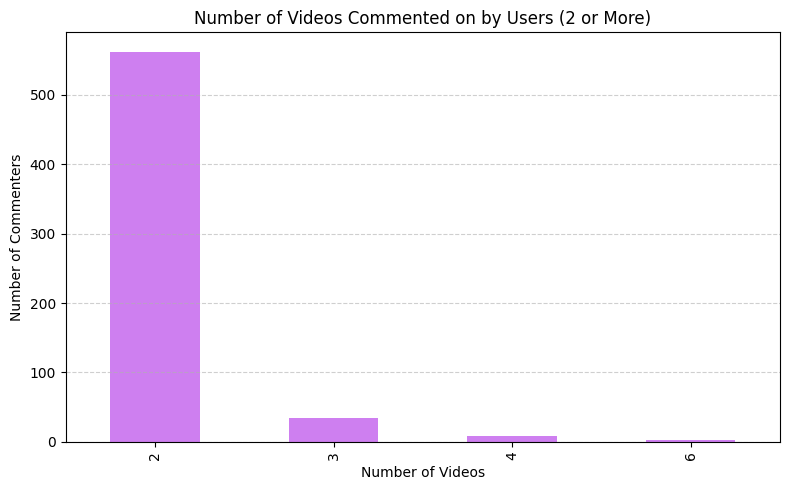

In [99]:
#visualization
import matplotlib.pyplot as plt

# Count how many videos each user commented on
author_video_counts = df.groupby('author')['video_id'].nunique()

# Count frequency of video counts (e.g. how many users commented on 2, 3, 4... videos)
video_freq_distribution = author_video_counts.value_counts().sort_index()

# Filter out users who only commented on 1 video
video_freq_distribution_filtered = video_freq_distribution[video_freq_distribution.index >= 2]

# Plot
plt.figure(figsize=(8, 5))
video_freq_distribution_filtered.plot(kind='bar', color='#ce7ff0')
plt.title('Number of Videos Commented on by Users (2 or More)')
plt.xlabel('Number of Videos')
plt.ylabel('Number of Commenters')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



8. Commenter behaviours --> are some more emotionally extreme?


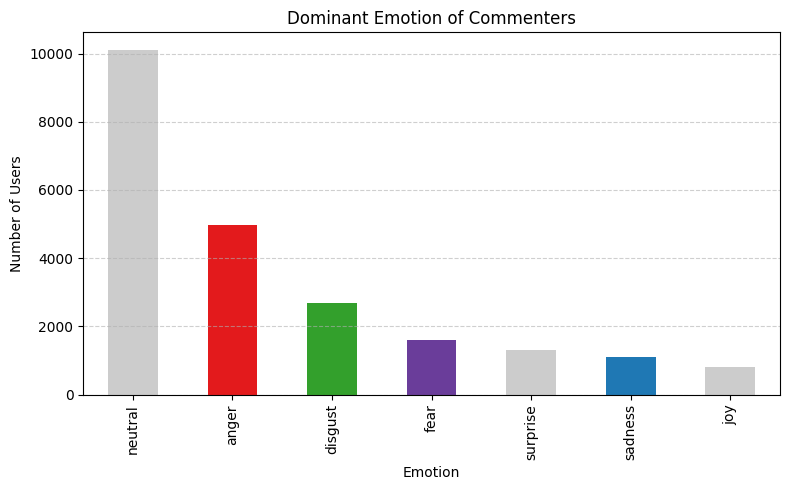

In [102]:
import pandas as pd 
import matplotlib.pyplot as plt

df = pd.read_csv("comments_processing2.csv")

#count how many times an emotion is shown by a user 
commenter_emotion_count = df.groupby(['author','emotion']).size().unstack(fill_value=0)

# calculate the emotion percentages 
emotion_percentages = commenter_emotion_count.div(commenter_emotion_count.sum(axis=1), axis=0)

#find the dominant emotion for each user
dominant_emotion = emotion_percentages.idxmax(axis=1)

#count how many commenters are dominated by each emotion
dominant_emotion_counts = dominant_emotion.value_counts()

#visualization 

#colors 
motion_colors = {
    'joy': '#f5ec42',
    'sadness': '#1f78b4',
    'anger': '#e31a1c',
    'fear': '#6a3d9a',
    'disgust': '#33a02c',
    'surprise': '#f542e3',
    'neutral': '#bdbdbd'
}
bar_colors = [emotion_colors.get(e, '#cccccc') for e in dominant_emotion_counts.index]

# Plot
plt.figure(figsize=(8, 5))
dominant_emotion_counts.plot(kind='bar', color=bar_colors)
plt.title('Dominant Emotion of Commenters')
plt.xlabel('Emotion')
plt.ylabel('Number of Users')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


9. Are specific emotions contagious?


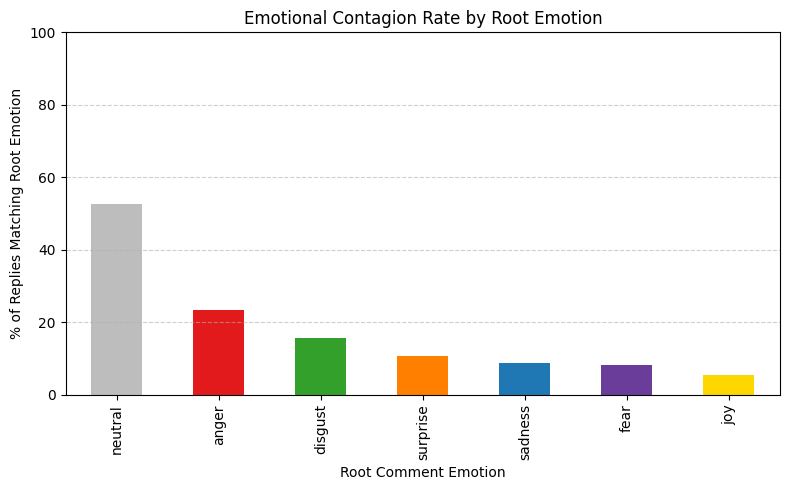

In [112]:

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("comments_processing3.csv")

# Create a lookup: comment_id → emotion
emotion_lookup = df.set_index('comment_id')['emotion']

# Keep only replies whose parent_id exists in our lookup
replies = df[df['parent_id'].isin(emotion_lookup.index)].copy()

# Map the parent emotion to each reply
replies['parent_emotion'] = replies['parent_id'].map(emotion_lookup)

# Check if reply's emotion matches its parent's
replies['emotion_match'] = replies['emotion'] == replies['parent_emotion']

# Group by parent emotion and then calulate the match rate
contagion_rate = replies.groupby('parent_emotion')['emotion_match'].mean().sort_values(ascending=False)

# Multiply by 100 to get percentage 
contagion_rate = contagion_rate * 100

# Color map
emotion_colors = {
    'joy': '#ffd700',
    'sadness': '#1f78b4',
    'anger': '#e31a1c',
    'fear': '#6a3d9a',
    'disgust': '#33a02c',
    'surprise': '#ff7f00',
    'neutral': '#bdbdbd'
}

bar_colors = [emotion_colors.get(e, '#cccccc') for e in contagion_rate.index]

# Plot
plt.figure(figsize=(8, 5))
contagion_rate.plot(kind='bar', color=bar_colors)
plt.title('Emotional Contagion Rate by Root Emotion')
plt.ylabel('% of Replies Matching Root Emotion')
plt.xlabel('Root Comment Emotion')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()




    Top 10 most emotionally extreme users


In [109]:
import pandas as pd

#load the data 
df = pd.read_csv("comments_processing3.csv")

# Count number of each emotion per author
emotion_by_author = df.groupby(['author', 'emotion']).size().unstack(fill_value=0)

# Calculate emotion percentages
emotion_percentages = emotion_by_author.div(emotion_by_author.sum(axis=1), axis=0)

# Get dominant emotion and its proportion
dominant_emotion = emotion_percentages.idxmax(axis=1)
dominant_share = emotion_percentages.max(axis=1)

# Combine into a single DataFrame
extreme_users = pd.DataFrame({
    'dominant_emotion': dominant_emotion,
    'dominant_share': dominant_share
})

# Only include users with at least 5 comments
extreme_users['total_comments'] = emotion_by_author.sum(axis=1)
extreme_users = extreme_users[extreme_users['total_comments'] >= 5]  # adjust threshold as needed

# Sort by dominance and pick top 10
top_extreme_users = extreme_users.sort_values(by='dominant_share', ascending=False).head(10)

print(top_extreme_users.head(10))





           dominant_emotion  dominant_share  total_comments
author                                                     
user 9423           neutral             1.0               8
user 5652          surprise             1.0              19
user 10411            anger             1.0               6
user 3532             anger             1.0               5
user 11234            anger             1.0               7
user 19327          neutral             1.0               7
user 5784           neutral             1.0               8
user 5781           neutral             1.0               5
user 19306          neutral             1.0               7
user 9409           neutral             1.0              18


10. Information on those who comment on several different videos


    Who are they


In [114]:
import pandas as pd 

df = pd.read_csv("comments_processing3.csv")

# Group by author and count unique video_ids
author_video_counts = df.groupby('author')['video_id'].nunique()

# Filter to authors who commented on 4 or more videos
multi_video_commenters = author_video_counts[author_video_counts >= 4]

# Sort and display top users
multi_video_commenters_sorted = multi_video_commenters.sort_values(ascending=False)

print(multi_video_commenters_sorted)
print(f"\nTotal commenters who commented on multiple videos: {len(multi_video_commenters)}")


author
user 30       6
user 56       6
user 4651     6
user 21108    4
user 16176    4
user 4        4
user 55       4
user 583      4
user 585      4
user 808      4
user 8820     4
Name: video_id, dtype: int64

Total commenters who commented on multiple videos: 11


    How many replies do they recieve


In [117]:
import pandas as pd 

#load the csv file 
df = pd.read_csv("comments_processing3.csv")

#count how many times each parent appears as a parent id
video_counts = df.groupby('author')['video_id'].nunique()

#get authors that commented on 4 or more videos 
active_authors = video_counts[video_counts >= 4].index

# Count how many times each comment_id was replied to
reply_counts = df['parent_id'].value_counts()

# Map number of replies to each comment in filtered_df (in-memory only)
df['num_replies'] = df['comment_id'].map(reply_counts).fillna(0).astype(int)

# filter for commnety only made by the active authors
active_comments = df[df['author'].isin(active_authors)]

# Group by author and sum up replies
user_reply_totals = active_comments.groupby('author')['num_replies'].sum().reset_index()

# Rename columns and print
user_reply_totals.columns = ['user', 'total_replies_received']

print(user_reply_totals.sort_values(by='total_replies_received', ascending=False))




          user  total_replies_received
4    user 4651                      32
1   user 21108                      17
3       user 4                       7
7     user 583                       3
0   user 16176                       0
2      user 30                       0
5      user 55                       0
6      user 56                       0
8     user 585                       0
9     user 808                       0
10   user 8820                       0


    How many times have they commented in general


In [119]:
import pandas as pd

# Load the dataset
df = pd.read_csv("comments_processing3.csv")

# Count how many unique videos each author has commented on
author_video_counts = df.groupby('author')['video_id'].nunique()

# Filter for authors who commented on 4+ videos
active_authors = author_video_counts[author_video_counts >= 4].index

# Filter main dataframe to only those authors
active_comments = df[df['author'].isin(active_authors)]

# Count how many comments each of those users made (across all videos)
user_comment_counts = active_comments['author'].value_counts().reset_index()
user_comment_counts.columns = ['user', 'total_comments']

# print the result
print(user_comment_counts.sort_values(by='total_comments', ascending=False))


          user  total_comments
0    user 4651              42
1      user 56              31
2   user 16176              25
3     user 585              21
4      user 30              15
5   user 21108              13
6    user 8820              12
7     user 808              11
8      user 55               6
9       user 4               4
10    user 583               4


    What emotions do their comments show


           dominant_emotion  total_comments
author                                     
user 4651           neutral              42
user 56             neutral              31
user 16176          neutral              25
user 585            neutral              21
user 30             neutral              15
user 21108          neutral              13
user 8820           neutral              12
user 808            neutral              11
user 55             disgust               6
user 4              neutral               4
user 583            neutral               4


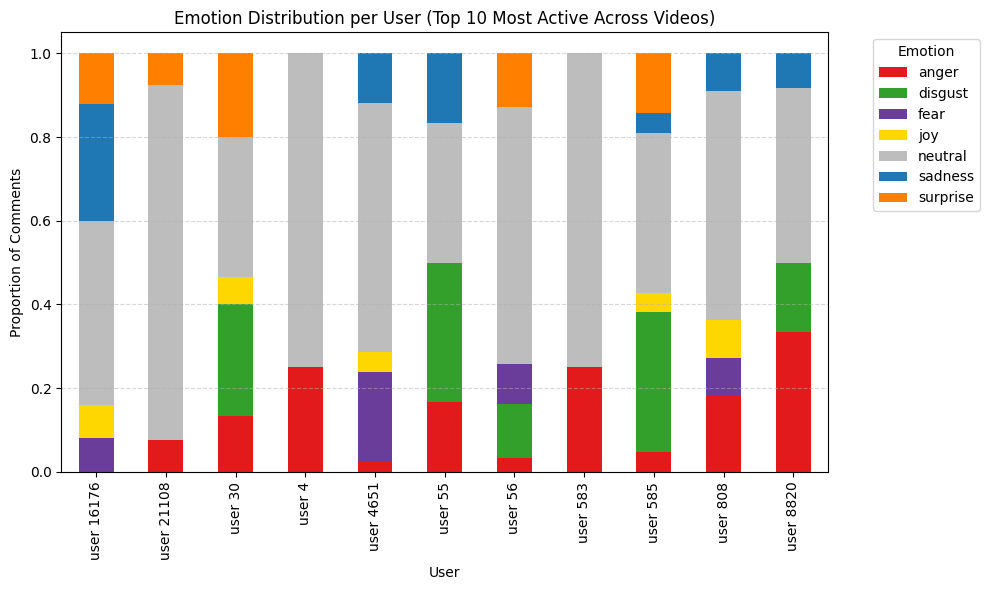

In [124]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("comments_processing3.csv")

# Count how many unique videos each author has commented on
author_video_counts = df.groupby('author')['video_id'].nunique()

# Filter for authors who commented on 4+ videos
active_authors = author_video_counts[author_video_counts >= 4].index

# Filter main dataframe to only those authors
active_comments = df[df['author'].isin(active_authors)]

# count how many comments per emotion 
emotion_counts = active_comments.groupby(['author','emotion']).size().unstack(fill_value=0)

#normalize to get percentage of comments in each emotion per user 
emotion_percentages = emotion_counts.div(emotion_counts.sum(axis=1), axis=0)

dominant_emotion = emotion_percentages.idxmax(axis=1)

# Combine with total comment count
emotion_summary = pd.DataFrame({
    'dominant_emotion': dominant_emotion,
    'total_comments': emotion_counts.sum(axis=1)
})

# Preview
print(emotion_summary.sort_values(by='total_comments', ascending=False))


#visualize 
# chose colors for each emotion 
emotion_colors = {
    'joy': '#ffd700',
    'sadness': '#1f78b4',
    'anger': '#e31a1c',
    'fear': '#6a3d9a',
    'disgust': '#33a02c',
    'surprise': '#ff7f00',
    'neutral': '#bdbdbd'
}
# Align colors with DataFrame columns
colors = [emotion_colors.get(e, '#cccccc') for e in emotion_percentages.columns]

# Plot
emotion_percentages.plot(
    kind='bar',
    stacked=True,
    color=colors,
    figsize=(10, 6)
)

plt.title('Emotion Distribution per User (Top 10 Most Active Across Videos)')
plt.xlabel('User')
plt.ylabel('Proportion of Comments')
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


    What sentiment do the comments show


           dominant_emotion  total_comments
author                                     
user 4651          positive              42
user 56            negative              31
user 16176         positive              25
user 585           negative              21
user 30             neutral              15
user 21108         positive              13
user 8820           neutral              12
user 808           positive              11
user 55             neutral               6
user 4              neutral               4
user 583            neutral               4


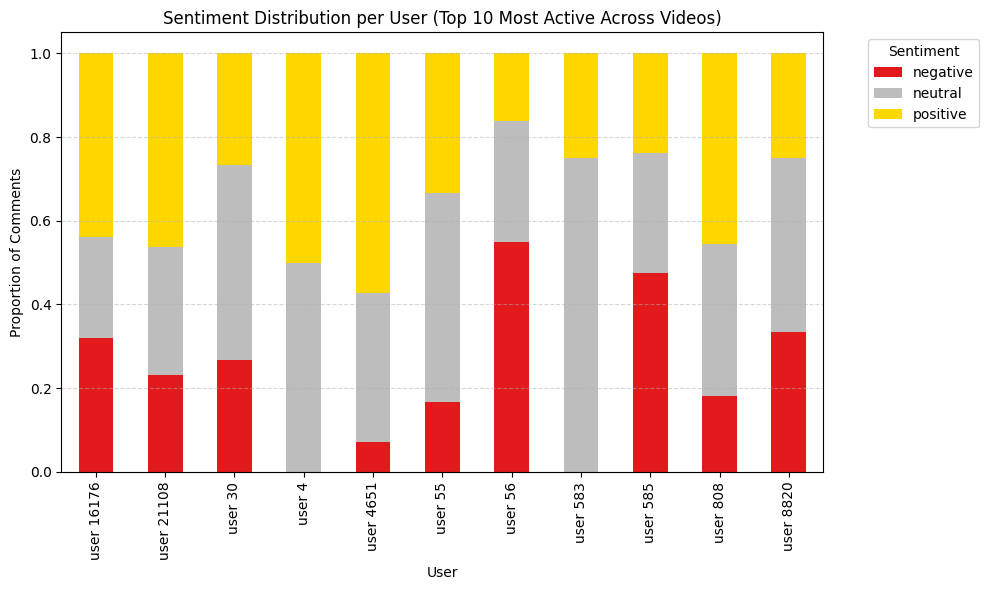

In [162]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("comments_processing3.csv")

# Count how many unique videos each author has commented on
author_video_counts = df.groupby('author')['video_id'].nunique()

# Filter for authors who commented on 4+ videos
active_authors = author_video_counts[author_video_counts >= 4].index

# Filter main dataframe to only those authors
active_comments = df[df['author'].isin(active_authors)]

# count how many comments per emotion 
sentiment_counts = active_comments.groupby(['author','sentiment_class']).size().unstack(fill_value=0)

#normalize to get percentage of comments in each emotion per user 
sentiment_percentages = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0)

dominant_sentiment= sentiment_percentages.idxmax(axis=1)

# Combine with total comment count
sentiment_summary = pd.DataFrame({
    'dominant_emotion': dominant_sentiment,
    'total_comments': sentiment_counts.sum(axis=1)
})

# Preview
print(sentiment_summary.sort_values(by='total_comments', ascending=False))


#visualize 
# chose colors for each emotion 
sentiment_colors = {
    'positive': '#ffd700',
    'negative': '#e31a1c',
    'neutral': '#bdbdbd'
}
# Align colors with DataFrame columns
colors = [sentiment_colors.get(s, '#cccccc') for s in sentiment_percentages.columns]

# Plot
sentiment_percentages.plot(
    kind='bar',
    stacked=True,
    color=colors,
    figsize=(10, 6)
)

plt.title('Sentiment Distribution per User (Top 10 Most Active Across Videos)')
plt.xlabel('User')
plt.ylabel('Proportion of Comments')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


    Emotion of the reply comments


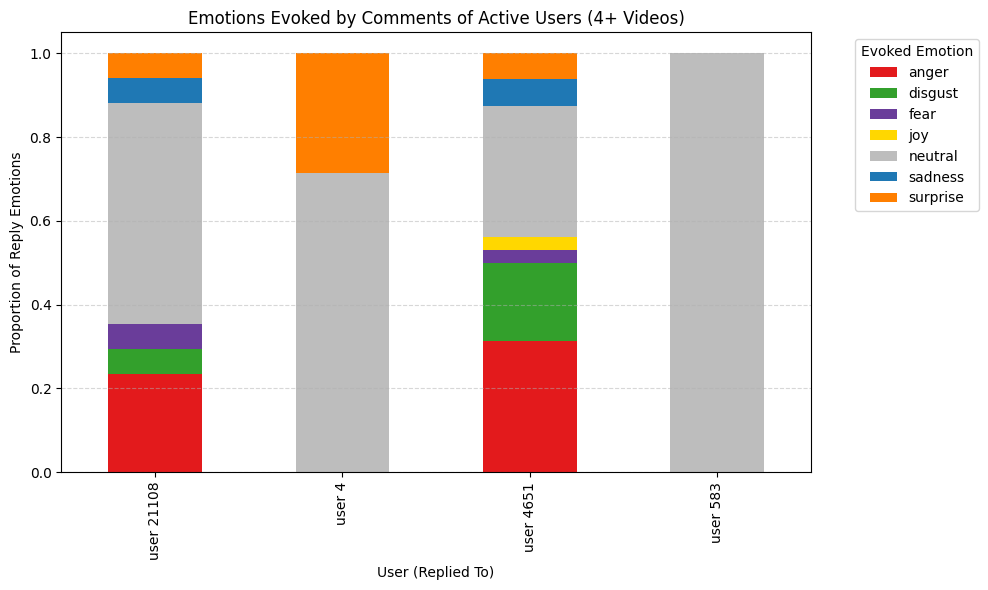

In [125]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("comments_processing3.csv")

# Count how many unique videos each author has commented on
author_video_counts = df.groupby('author')['video_id'].nunique()

# Filter for authors who commented on 4+ videos
active_authors = author_video_counts[author_video_counts >= 4].index

# Filter main dataframe to only those authors
active_comments = df[df['author'].isin(active_authors)]

comment_author_lookup = active_comments.set_index('comment_id')['author']

# Filter replies that replied to active user comments
replies = df[df['parent_id'].isin(comment_author_lookup.index)].copy()

# Add a column showing which user they replied to
replies['replied_to_author'] = replies['parent_id'].map(comment_author_lookup)

# Drop replies without a known author (just in case)
replies = replies[replies['replied_to_author'].notnull()]

# count how many comments per emotion 
emotion_evoked = replies.groupby(['replied_to_author','emotion']).size().unstack(fill_value=0)

#normalize to get percentage of comments in each emotion per user 
emotion_percentages = emotion_evoked.div(emotion_evoked.sum(axis=1), axis=0)

#visualize 
# chose colors for each emotion 
emotion_colors = {
    'joy': '#ffd700',
    'sadness': '#1f78b4',
    'anger': '#e31a1c',
    'fear': '#6a3d9a',
    'disgust': '#33a02c',
    'surprise': '#ff7f00',
    'neutral': '#bdbdbd'
}
# Align colors with DataFrame columns
colors = [emotion_colors.get(e, '#cccccc') for e in emotion_percentages.columns]

# Plot
emotion_percentages.plot(
    kind='bar',
    stacked=True,
    color=colors,
    figsize=(10, 6)
)

plt.title('Emotions Evoked by Comments of Active Users (4+ Videos)')
plt.xlabel('User (Replied To)')
plt.ylabel('Proportion of Reply Emotions')
plt.legend(title='Evoked Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

11. Analysis of people showing joy


    Who are they


In [126]:
import pandas as pd 

df = pd.read_csv("comments_processing3.csv")

# filter for comments that have the emotion 'Joy' 
joy_comments = df[df['emotion']== 'joy']

# export to csv file 
joy_comments.to_csv("joy_comments.csv", index=False)

In [128]:
for text in joy_comments['text'].sample(10, random_state=1):
    print("-", text)


- Stay strong. God bless u and Srilanka.
Sincerely
Your brother
From Pakistan
-  @Blondie-ic3wo  thank you for your comments 😄
-  @carpediemarts705  he has 1 billion dollars in Russian banks
He is going to retire comfortably there
- Shalom from Israel thanks for your support ❤
- The song is called “To See the Light” by Efrat Gosh. The official music video on YouTube has English subtitles. Beautiful beautiful song.
- Festival and dancing on Palestinian bloods that is what Israel doing for decades
- as peacefull as the religion of peace
- I vote for Israel🇮🇱
- @saintghost-wc8kx  yeah, you've got no option rather say it's funny to hide your sh*tty religion ISLAMs cancerous ideology, which has spread stink in the whole world. More power to #Exmuslims who are understanding this & living a relieved life.
- Don't cry...Didn't you have a jubilant celebration by dancing and shouting: "Aulah Akber..Aulah Akber from that loudspeaker over your successful victory abducting and killing of the Israel

In [131]:
# names of the people
import pandas as pd 

df = pd.read_csv("joy_comments.csv")

user_count = df["author"].nunique()

user_names = df['author'].unique()

# Print results
print(f"Number of unique Users in joy comments: {user_count}")
print("User names:")
print(user_names)


Number of unique Users in joy comments: 1370
User names:
['user 13' 'user 18' 'user 23' ... 'user 22590' 'user 22597' 'user 22508']


    Number of responses


In [133]:
import pandas as pd 

df = pd.read_csv("comments_processing3.csv")
joy_df = pd.read_csv("joy_comments.csv")

#count replies per comment 
replies = df['parent_id'].value_counts()

#map number of replies to each joy comment 
joy_df['num_replies'] = joy_df['comment_id'].map(reply_counts).fillna(0).astype(int)

# sum of replies per author
replies_per_author = joy_df.groupby('author')['num_replies'].sum().sort_values(ascending=False)

print(replies_per_author.head(20))


author
user 6386     367
user 15057    203
user 881      144
user 8890      96
user 14837     66
user 8998      65
user 12136     49
user 2383      40
user 14635     34
user 11112     34
user 14891     34
user 14241     33
user 13461     32
user 10323     31
user 9575      31
user 17135     28
user 11283     28
user 15003     25
user 4041      24
user 20534     23
Name: num_replies, dtype: int64


    Likes recieved


In [134]:
likes_count = joy_df.groupby('author')['likes'].sum().sort_values(ascending=False)
print(likes_count.head(10))

author
user 8890     4817
user 15057    4300
user 6386     3600
user 14837    1300
user 881      1100
user 12136     949
user 11112     898
user 15443     852
user 15003     763
user 14635     735
Name: likes, dtype: int64


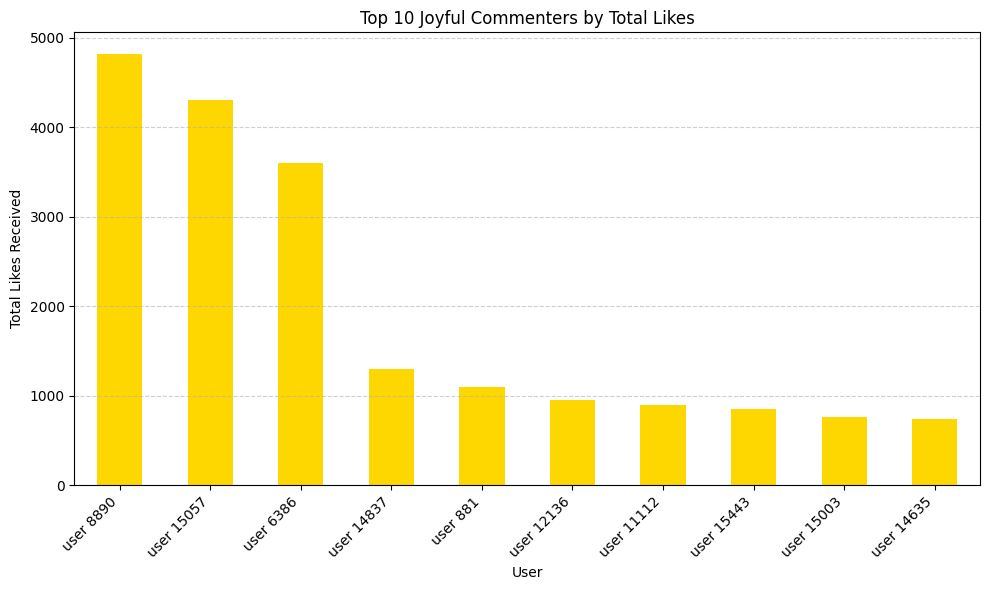

In [136]:
#Visualize 

import pandas as pd 
import matplotlib.pyplot as plt

#load joy comments 
df = pd.read_csv("joy_comments.csv")

#group by author and sum up the likes 
likes_per_author = df.groupby('author')['likes'].sum().sort_values(ascending=False)

#select the top 10 liked 
top_liked = likes_per_author.head(10)

#plot 
plt.figure(figsize=(10,6))
top_liked.plot(kind='bar', color='#ffd700')  # gold for joy
plt.title('Top 10 Joyful Commenters by Total Likes')
plt.xlabel('User')
plt.ylabel('Total Likes Received')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

    Emotion of the replies


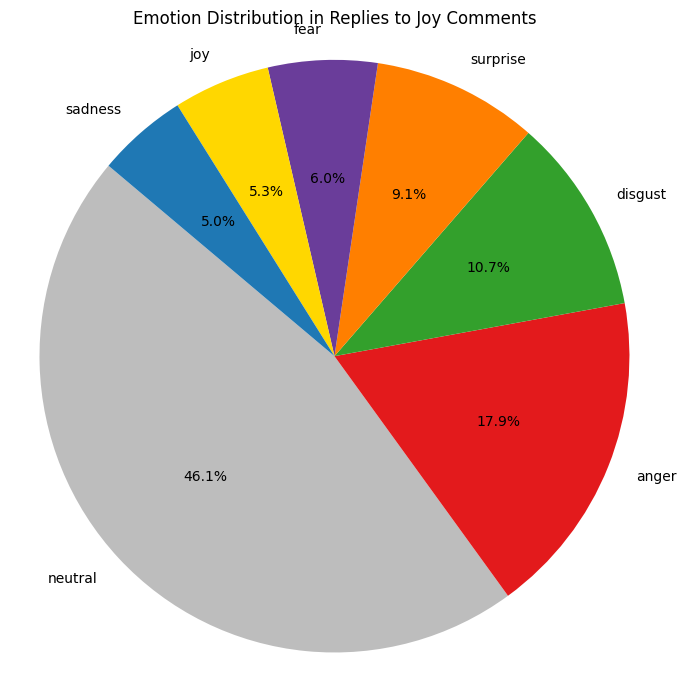

In [137]:
import pandas as pd 
import matplotlib.pyplot as plt 

# load all the data 
df = pd.read_csv("comments_processing3.csv")
joy_df = pd.read_csv("joy_comments.csv")

#get all comment id of joy comments 
joy_comment_ids = joy_df['comment_id'].tolist()

#filter replies to the joy comments 
replies = df[df['parent_id'].isin(joy_comment_ids)]

#count the emotion distribution 
emotion_counts = replies['emotion'].value_counts()
#define the colors 
emotion_colors = {
    'joy': '#ffd700',
    'sadness': '#1f78b4',
    'anger': '#e31a1c',
    'fear': '#6a3d9a',
    'disgust': '#33a02c',
    'surprise': '#ff7f00',
    'neutral': '#bdbdbd'
}
colors = [emotion_colors.get(emotion, '#cccccc') for emotion in emotion_counts.index]

#plot 
plt.figure(figsize=(7, 7))
plt.pie(
    emotion_counts,
    labels=emotion_counts.index,
    autopct='%1.1f%%',
    colors=colors,
    startangle=140
)
plt.title('Emotion Distribution in Replies to Joy Comments')
plt.axis('equal')  
plt.tight_layout()
plt.show()

    Sentiment of the replies


sentiment_class
negative    922
positive    893
neutral     789
Name: count, dtype: int64


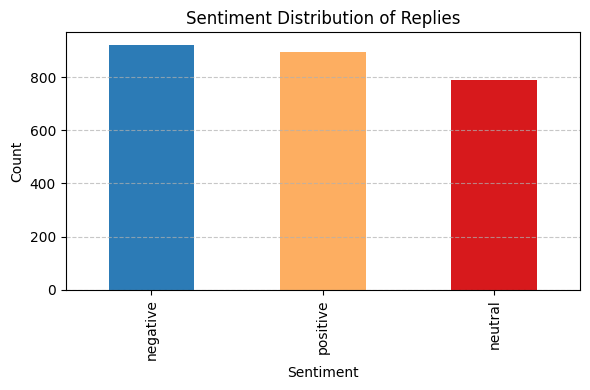

In [144]:
import pandas as pd 
import matplotlib.pyplot as plt 

# load all the data 
df = pd.read_csv("comments_processing3.csv")
joy_df = pd.read_csv("joy_comments.csv")

#get all comment id of joy comments 
joy_comment_ids = joy_df['comment_id'].tolist()

#filter replies to the joy comments 
replies = df[df['parent_id'].isin(joy_comment_ids)]

#count the emotion distribution 
sentiment_counts = replies['sentiment_class'].value_counts(dropna=True)

print(sentiment_counts)

#define the colors 
sentiment_colors = {
    'positive': '#ffd700',
    'negative': '#e31a1c',
    'neutral': '#bdbdbd'
}
colors = [sentiment_colors.get(sent, '#cccccc') for sent in sentiment_counts.index]

#plot 
#plt.figure(figsize=(7, 7))
#plt.pie(
 #   sentiment_counts,
  #  labels=sentiment_counts.index,
   # autopct='%1.1f%%',
    #colors=colors,
    #startangle=140
#)
#plt.title('Sentiment Distribution in Replies to Joy Comments')
#plt.axis('equal')  
#plt.tight_layout()
#plt.show()

# Plot as a bar chart
sentiment_counts.plot(
    kind='bar',
    color=['#2c7bb6', '#fdae61', '#d7191c'],  # blue=positive, orange=neutral, red=negative
    figsize=(6, 4)
)

plt.title('Sentiment Distribution of Replies')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


    Emotion Polarity of replies


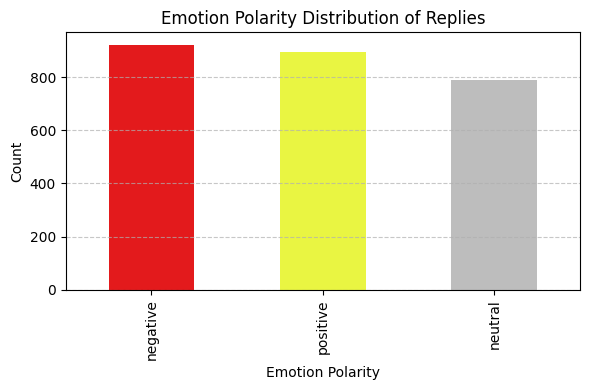

In [149]:
import pandas as pd 
import matplotlib.pyplot as plt 

# load all the data 
df = pd.read_csv("comments_processing3.csv")
joy_df = pd.read_csv("joy_comments.csv")

#get all comment id of joy comments 
joy_comment_ids = joy_df['comment_id'].tolist()

#filter replies to the joy comments 
replies = df[df['parent_id'].isin(joy_comment_ids)]

#count the emotion distribution 
polarity_counts = replies['emotion_polarity'].value_counts(dropna=True)
#define the colors 
polarity_colors = {
    'positive': '#ffd700',
    'negative': '#e31a1c',
    'neutral': '#bdbdbd'
}
colors = [polarity_colors.get(pol, '#cccccc') for pol in polarity_counts.index]

sentiment_counts.plot(
    kind='bar',
    color=['#e31a1c', '#e9f542', '#bdbdbd'],  # blue=positive, orange=neutral, red=negative
    figsize=(6, 4)
)

plt.title('Emotion Polarity Distribution of Replies')
plt.xlabel('Emotion Polarity')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

    How many times have they commented


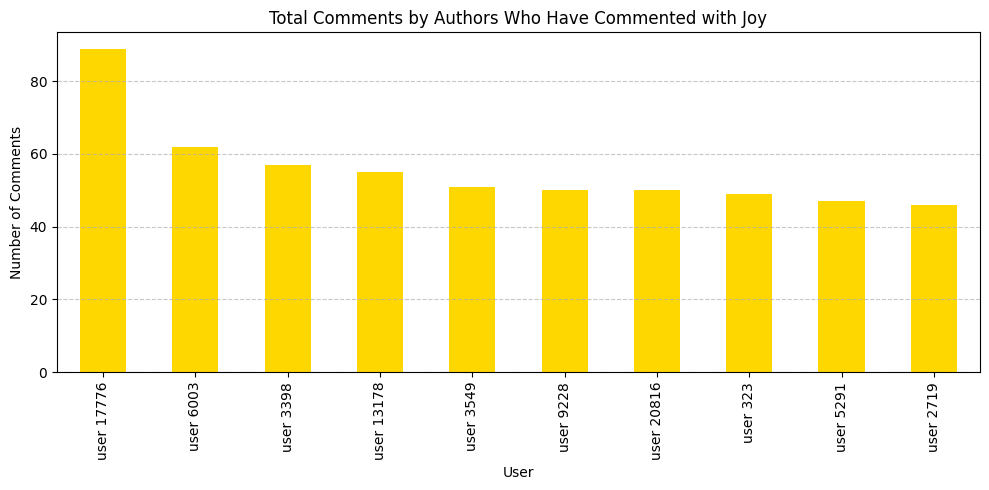

In [154]:
import pandas as pd 
import matplotlib.pyplot as plt 

#load data 
df = pd.read_csv("comments_processing3.csv")
joy_df = pd.read_csv("joy_comments.csv")

#get all comment id of joy comments 
joy_users = joy_df['author'].unique()
joy_users_df = df[df['author'].isin(joy_users)]

comment_counts = joy_users_df['author'].value_counts()

# Plot top N (e.g. top 10 most active joyful authors)
comment_counts.head(10).plot(
    kind='bar',
    color='#ffd700',
    figsize=(10, 5),
    title='Total Comments by Authors Who Have Commented with Joy',
)
plt.xlabel('User')
plt.ylabel('Number of Comments')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



    How many videos have these 'joy' users commented on


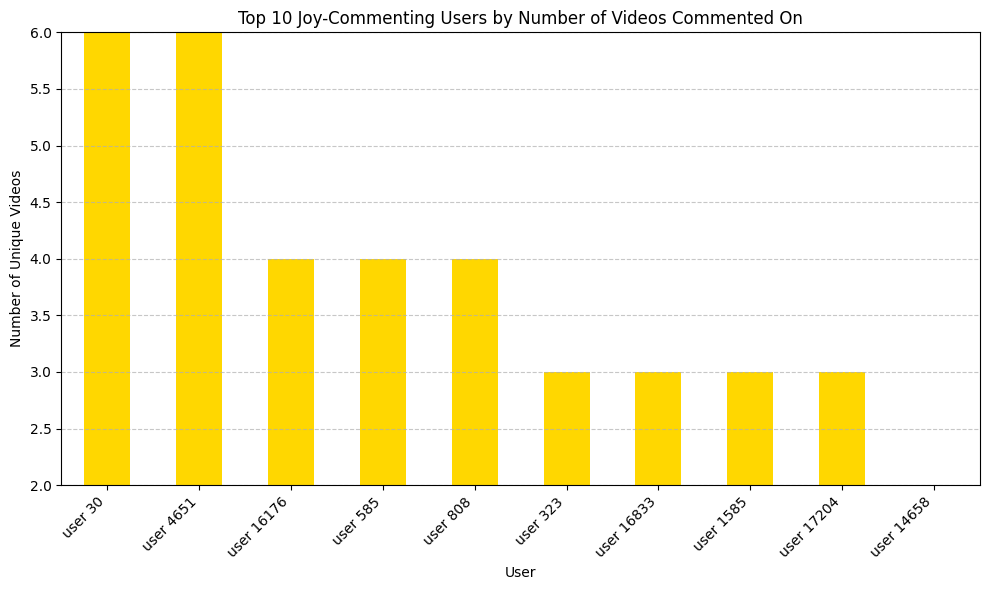

In [160]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("comments_processing3.csv")
joy_df = pd.read_csv("joy_comments.csv")

# Get all unique joy-commenting users
joy_users = joy_df['author'].unique()

# Filter full DF for joy-users
joy_users_df = df[df['author'].isin(joy_users)]

# Count number of unique videos per joy-user
unique_videos_per_user = joy_users_df.groupby('author')['video_id'].nunique()

# Sort & take top 10
top_10_users = unique_videos_per_user.sort_values(ascending=False).head(10)

# Get max videos
max_videos = top_10_users.max()

# Plot
plt.figure(figsize=(10, 6))
top_10_users.plot(
    kind='bar',
    color='#ffd700'
)
plt.title('Top 10 Joy-Commenting Users by Number of Videos Commented On')
plt.xlabel('User')
plt.ylabel('Number of Unique Videos')
plt.ylim(2, max_videos)  # set y axis lower limit to 2
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
